Let's Scrape News Articles about the Companies
---

In [1]:
import newspaper 
import bs4 as bs
import requests
import spacy
import re
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import pickle
import os 

Using TensorFlow backend.


In [2]:
def tokenize(sent):
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]

In [3]:
# Top Tech Companies
ticker_tech_comp = ['GOOG', "AMZN", "FB", "AAPL", "MSFT"]
tech_comp = ["google","amazon","facebook","apple","microsoft"]

Which News Site did I use?
----
I chose to scrape articles from The Verge because after looking at several sources (eg. CNN, techcrunch, etc...) I was able to scrape articles about the companies in a wider date range, which is important as my financial data runs from March, 24, 2014 to the current day

In [103]:
theverge_paper = newspaper.build('https://www.theverge.com/tech', memoize_articles=False)

In [159]:
with open("theverge_paper.pickle", "wb") as f:
    pickle.dump(theverge_paper.articles, f)

How do I determine if the News Article is Relevant?
---
To determine if an article is talking about a specific company, I run through the company urls which contains the article's title. If the company name is in the title, then I conclude that means that the article is about the company.

In [242]:
# Create a tuple with the article and the article url
goog_verge = []
amzn_verge = []
fb_verge = []
apple_verge = []
msft_verge = []

for article in theverge_paper.articles:
    for comp in tech_comp:
        if comp in article.url and comp is "google" and "comment" not in article.url:
            goog_verge.append((article, article.url))
        if comp in article.url and comp is "amazon" and "comment" not in article.url:
            amzn_verge.append((article, article.url))
        if comp in article.url and comp is "facebook" and "comment" not in article.url:
            fb_verge.append((article, article.url))
        if comp in article.url and comp is "apple" and "comment" not in article.url:
            apple_verge.append((article, article.url))
        if comp in article.url and comp is "microsoft" and "comment" not in article.url:
            msft_verge.append((article, article.url))
            

In [402]:
# Convert the article objects into texts, but retain the tuple shape
for i in range(len(goog_verge)):
    goog_verge[i] = (goog_verge[i][0].text, goog_verge[i][1])
    
for i in range(len(amzn_verge)):
    amzn_verge[i] = (amzn_verge[i][0].text, amzn_verge[i][1])

for i in range(len(fb_verge)):
    fb_verge[i] = (fb_verge[i][0].text, fb_verge[i][1])

for i in range(len(apple_verge)):
    apple_verge[i] = (apple_verge[i][0].text, apple_verge[i][1])

for i in range(len(msft_verge)):
    msft_verge[i] = (msft_verge[i][0].text, msft_verge[i][1])


Pickle Articles
----
If the articles have already been pickled, the articles will be loaded

In [4]:
# Pickle all of the modified articles so it can just be loaded
if not os.path.exists('articles'):
    with open("articles/google_article.pickle", "wb") as f:
        pickle.dump(goog_verge, f)

    with open("articles/amazon_article.pickle", "wb") as f:
        pickle.dump(amzn_verge, f)

    with open("articles/facebook_article.pickle", "wb") as f:
        pickle.dump(fb_verge, f)

    with open("articles/apple_article.pickle", "wb") as f:
        pickle.dump(apple_verge, f)

    with open("articles/microsoft_article.pickle", "wb") as f:
        pickle.dump(msft_verge, f)

else:
    goog_verge = pickle.load(open("articles/google_article.pickle", "rb"))
    amzn_verge = pickle.load(open("articles/amazon_article.pickle", "rb"))
    fb_verge = pickle.load(open("articles/facebook_article.pickle", "rb"))
    apple_verge = pickle.load(open("articles/apple_article.pickle", "rb"))
    msft_verge = pickle.load(open("articles/microsoft_article.pickle", "rb"))



Next we want to create a vocabularly list for each of the words used in the article.
We will put this in a dictionary with an index associated with each of the vocab keys

How do we represent the text as vectors?
----
First, we will create a vocabularly of all the words seen in the current articles. This will be a dictionary of all the words with an associated index next to it. For future articles seen, if there are unknown words that are not found in the vocabulary, I have allocated the last index as an unknown vocab slot, so that any unseen words will simply be given that index

In [5]:
# Run through each article and append new vocab in vocab list
vocab = set()
    
for i in range(len(goog_verge)):
    vocab |= set((tokenize(goog_verge[i][0])))
    
for i in range(len(amzn_verge)):
    vocab |= set((tokenize(amzn_verge[i][0])))

for i in range(len(fb_verge)):
    vocab |= set((tokenize(fb_verge[i][0])))

for i in range(len(apple_verge)):
    vocab |= set((tokenize(apple_verge[i][0])))

for i in range(len(msft_verge)):
    vocab |= set((tokenize(msft_verge[i][0])))
    

/Users/Angus/anaconda/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [6]:
# Put in a dictionary with an index for each of the vocabulary
# Reserve 0 for masking via pad_sequences
vocab = sorted(vocab)
vocab_id = dict((word, i + 1) for i, word in enumerate(vocab))
vocab_size = len(vocab) + 1

Finding Maximum Article Length
---
We wish to find the max length of all the articles so that when we put it into the model all of it will be the same size, and thus the model will be able to use it as input. For articles less than max length, simply append 0 onto the end of the vector until it reaches the max length

In [7]:
# Get the max article length for tokenize 
article_len = []

for i in range(len(goog_verge)):
    article_len.append(len(tokenize(goog_verge[i][0])))
    
for i in range(len(amzn_verge)):
    article_len.append(len(tokenize(amzn_verge[i][0])))
    
for i in range(len(fb_verge)):
    article_len.append(len(tokenize(fb_verge[i][0])))
    
for i in range(len(apple_verge)):
    article_len.append(len(tokenize(apple_verge[i][0])))
    
for i in range(len(msft_verge)):
    article_len.append(len(tokenize(msft_verge[i][0])))
    
article_maxlen = max(article_len)

/Users/Angus/anaconda/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [8]:
def vectorize(article, vocab_id, article_maxlen):
    word_id = []
    for word in article:
        word_id.append(vocab_id[word]) 
    return pad_sequences([word_id], maxlen=article_maxlen)

In [9]:
goog_vect_verge = goog_verge 
amzn_vect_verge = amzn_verge 
fb_vect_verge = fb_verge 
apple_vect_verge = apple_verge 
msft_vect_verge = msft_verge 

In [10]:
'''
for i in range(len(goog_vect_verge)):
    goog_vect_verge[i][0] = vectorize(tokenize(goog_vect_verge[i][0]), vocab_id, article_maxlen)
    
for i in range(len(amzn_vect_verge)):
    article_len.append(len(tokenize(amzn_verge[i][0])))
    
for i in range(len(fb_vect_verge)):
    article_len.append(len(tokenize(fb_verge[i][0])))
    
for i in range(len(apple_vect_verge)):
    article_len.append(len(tokenize(apple_verge[i][0])))
    
for i in range(len(msft_vect_verge)):
    article_len.append(len(tokenize(msft_verge[i][0])))
'''

'\nfor i in range(len(goog_vect_verge)):\n    goog_vect_verge[i][0] = vectorize(tokenize(goog_vect_verge[i][0]), vocab_id, article_maxlen)\n    \nfor i in range(len(amzn_vect_verge)):\n    article_len.append(len(tokenize(amzn_verge[i][0])))\n    \nfor i in range(len(fb_vect_verge)):\n    article_len.append(len(tokenize(fb_verge[i][0])))\n    \nfor i in range(len(apple_vect_verge)):\n    article_len.append(len(tokenize(apple_verge[i][0])))\n    \nfor i in range(len(msft_vect_verge)):\n    article_len.append(len(tokenize(msft_verge[i][0])))\n'

In [11]:
# Convert the text into vector representations
for i in range(len(goog_vect_verge)):
    goog_vect_verge[i] = (vectorize(tokenize(goog_vect_verge[i][0]), 
                                    vocab_id, 
                                    article_maxlen), 
                          goog_vect_verge[i][1])

for i in range(len(amzn_vect_verge)):
    amzn_vect_verge[i] = (vectorize(tokenize(amzn_vect_verge[i][0]), 
                                    vocab_id, 
                                    article_maxlen), 
                          amzn_vect_verge[i][1])

for i in range(len(fb_vect_verge)):
    fb_vect_verge[i] = (vectorize(tokenize(fb_vect_verge[i][0]), 
                                    vocab_id, 
                                    article_maxlen), 
                          fb_vect_verge[i][1])
    
for i in range(len(apple_vect_verge)):
    apple_vect_verge[i] = (vectorize(tokenize(apple_vect_verge[i][0]), 
                                    vocab_id, 
                                    article_maxlen), 
                          apple_vect_verge[i][1])
    
for i in range(len(msft_vect_verge)):
    msft_vect_verge[i] = (vectorize(tokenize(msft_vect_verge[i][0]), 
                                    vocab_id, 
                                    article_maxlen), 
                          msft_vect_verge[i][1])


/Users/Angus/anaconda/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


How did I fill in the missing Gaps for dates without articles
----

Since we only had ~20 articles spanning different dates from 2014-2017 since we were unable to scrape enough articles, I simply converted all of these articles into vector representations and filled in the spots where the articles were applicable. For example, if an article was released on May 1, 2017, I would use that article for the prediction for May 2, 2017. Also, since there were a lot of empty slots, i simply used the last seen article, for the empty slots; the idea being that the last seen article will affect future stock prices (this is the fillna ffill method)

In [12]:
df_goog = pd.read_csv('final_stock_features_with_date_dfs/{}.csv'.format('GOOG'))
vect_holder = pd.DataFrame(np.zeros((len(df_goog),article_maxlen)))
vect_holder = vect_holder.replace(0,np.nan)
df_goog = pd.concat([df_goog, vect_holder], axis=1)
df_goog.set_index('Date', inplace=True)

In [659]:
df_amzn = pd.read_csv('final_stock_features_with_date_dfs/{}.csv'.format('AMZN'))
df_amzn = pd.concat([df_amzn, vect_holder], axis=1)
df_amzn.set_index('Date', inplace=True)

In [674]:
df_fb = pd.read_csv('final_stock_features_with_date_dfs/{}.csv'.format('FB'))
df_fb = pd.concat([df_fb, vect_holder], axis=1)
df_fb.set_index('Date', inplace=True)

In [703]:
df_apple = pd.read_csv('final_stock_features_with_date_dfs/{}.csv'.format('AAPL'))
df_apple = pd.concat([df_apple, vect_holder], axis=1)
df_apple.set_index('Date', inplace=True)

In [709]:
df_msft = pd.read_csv('final_stock_features_with_date_dfs/{}.csv'.format('MSFT'))
df_msft = pd.concat([df_msft, vect_holder], axis=1)
df_msft.set_index('Date', inplace=True)

Issues with Missing Articles
---
Unfortunately, this part was done mostly manually as there were a lot of missing articles, in the future, it is important to find a reliable source of articles for all the dates possible

In [13]:
df_goog.loc["2017-06-23",list(range(article_maxlen))] = list(goog_vect_verge[0][0].astype(int))
df_goog.loc["2017-06-15",list(range(article_maxlen))] = list(goog_vect_verge[1][0].astype(int))
df_goog.loc["2017-06-13",list(range(article_maxlen))] = list(goog_vect_verge[2][0].astype(int))
df_goog.loc["2017-06-20",list(range(article_maxlen))] = list(goog_vect_verge[3][0].astype(int))
df_goog.loc["2017-06-19",list(range(article_maxlen))] = list(goog_vect_verge[4][0].astype(int))
df_goog.loc["2017-06-13",list(range(article_maxlen))] = list(goog_vect_verge[5][0].astype(int))
df_goog.loc["2017-06-07",list(range(article_maxlen))] = list(goog_vect_verge[6][0].astype(int))
df_goog.loc["2017-04-24",list(range(article_maxlen))] = list(goog_vect_verge[7][0].astype(int))
df_goog.loc["2017-06-02",list(range(article_maxlen))] = list(goog_vect_verge[8][0].astype(int))
df_goog.loc["2017-05-25",list(range(article_maxlen))] = list(goog_vect_verge[9][0].astype(int))
df_goog.loc["2017-05-18",list(range(article_maxlen))] = list(goog_vect_verge[10][0].astype(int))
df_goog.loc["2017-05-11",list(range(article_maxlen))] = list(goog_vect_verge[11][0].astype(int))
df_goog.loc["2017-04-28",list(range(article_maxlen))] = list(goog_vect_verge[12][0].astype(int))
df_goog.loc["2017-04-27",list(range(article_maxlen))] = list(goog_vect_verge[13][0].astype(int))
df_goog.loc["2016-10-19",list(range(article_maxlen))] = list(goog_vect_verge[14][0].astype(int))
df_goog.loc["2017-05-31",list(range(article_maxlen))] = list(goog_vect_verge[15][0].astype(int))
df_goog.loc["2015-12-09",list(range(article_maxlen))] = list(goog_vect_verge[16][0].astype(int))
df_goog.loc["2014-03-28",list(range(article_maxlen))] = list(goog_vect_verge[17][0].astype(int))
df_goog.loc["2016-12-19",list(range(article_maxlen))] = list(goog_vect_verge[18][0].astype(int))

In [14]:
df_goog.fillna(method='ffill', inplace=True)

In [660]:
df_amzn.loc["2017-05-10",list(range(article_maxlen))] = list(amzn_vect_verge[0][0][0])
df_amzn.loc["2017-06-23",list(range(article_maxlen))] = list(amzn_vect_verge[1][0][0])
df_amzn.loc["2017-06-06",list(range(article_maxlen))] = list(amzn_vect_verge[2][0][0])
df_amzn.loc["2017-06-21",list(range(article_maxlen))] = list(amzn_vect_verge[3][0][0])
df_amzn.loc["2017-06-19",list(range(article_maxlen))] = list(amzn_vect_verge[4][0][0])
df_amzn.loc["2017-06-15",list(range(article_maxlen))] = list(amzn_vect_verge[5][0][0])
df_amzn.loc["2017-06-07",list(range(article_maxlen))] = list(amzn_vect_verge[6][0][0])
df_amzn.loc["2016-07-29",list(range(article_maxlen))] = list(amzn_vect_verge[9][0][0])
df_amzn.loc["2017-06-20",list(range(article_maxlen))] = list(amzn_vect_verge[10][0][0])
df_amzn.loc["2017-06-13",list(range(article_maxlen))] = list(amzn_vect_verge[11][0][0])
df_amzn.loc["2017-06-12",list(range(article_maxlen))] = list(amzn_vect_verge[12][0][0])
df_amzn.loc["2017-05-23",list(range(article_maxlen))] = list(amzn_vect_verge[13][0][0])
df_amzn.loc["2014-03-28",list(range(article_maxlen))] = list(amzn_vect_verge[14][0][0])


In [725]:
df_amzn.fillna(method='ffill', inplace=True)

In [675]:
df_fb.loc["2017-06-23",list(range(article_maxlen))] = list(fb_vect_verge[0][0][0])
df_fb.loc["2017-06-12",list(range(article_maxlen))] = list(fb_vect_verge[1][0][0])
df_fb.loc["2017-06-08",list(range(article_maxlen))] = list(fb_vect_verge[2][0][0])
df_fb.loc["2017-06-06",list(range(article_maxlen))] = list(fb_vect_verge[3][0][0])
df_fb.loc["2017-06-19",list(range(article_maxlen))] = list(fb_vect_verge[5][0][0])
df_fb.loc["2017-06-09",list(range(article_maxlen))] = list(fb_vect_verge[6][0][0])
df_fb.loc["2017-05-19",list(range(article_maxlen))] = list(fb_vect_verge[7][0][0])
df_fb.loc["2017-04-26",list(range(article_maxlen))] = list(fb_vect_verge[8][0][0])
df_fb.loc["2017-06-14",list(range(article_maxlen))] = list(fb_vect_verge[9][0][0])
df_fb.loc["2017-05-30",list(range(article_maxlen))] = list(fb_vect_verge[10][0][0])
df_fb.loc["2017-06-01",list(range(article_maxlen))] = list(fb_vect_verge[11][0][0])
df_fb.loc["2017-04-20",list(range(article_maxlen))] = list(fb_vect_verge[12][0][0])
df_fb.loc["2017-05-26",list(range(article_maxlen))] = list(fb_vect_verge[13][0][0])
df_fb.loc["2017-04-17",list(range(article_maxlen))] = list(fb_vect_verge[14][0][0])
df_fb.loc["2014-03-28",list(range(article_maxlen))] = list(fb_vect_verge[15][0][0])

In [726]:
df_fb.fillna(method='ffill', inplace=True)

In [704]:
df_apple.loc["2017-06-23",list(range(article_maxlen))] = list(apple_vect_verge[0][0][0])
df_apple.loc["2017-06-06",list(range(article_maxlen))] = list(apple_vect_verge[2][0][0])
df_apple.loc["2017-05-03",list(range(article_maxlen))] = list(apple_vect_verge[4][0][0])
df_apple.loc["2017-06-15",list(range(article_maxlen))] = list(apple_vect_verge[5][0][0])
df_apple.loc["2017-06-14",list(range(article_maxlen))] = list(apple_vect_verge[6][0][0])
df_apple.loc["2017-06-13",list(range(article_maxlen))] = list(apple_vect_verge[7][0][0])
df_apple.loc["2017-06-08",list(range(article_maxlen))] = list(apple_vect_verge[9][0][0])
df_apple.loc["2017-04-21",list(range(article_maxlen))] = list(apple_vect_verge[10][0][0])
df_apple.loc["2017-06-01",list(range(article_maxlen))] = list(apple_vect_verge[11][0][0])
df_apple.loc["2017-05-30",list(range(article_maxlen))] = list(apple_vect_verge[12][0][0])
df_apple.loc["2017-05-26",list(range(article_maxlen))] = list(apple_vect_verge[13][0][0])
df_apple.loc["2016-11-15",list(range(article_maxlen))] = list(apple_vect_verge[14][0][0])
df_apple.loc["2016-11-03",list(range(article_maxlen))] = list(apple_vect_verge[15][0][0])
df_apple.loc["2016-05-06",list(range(article_maxlen))] = list(apple_vect_verge[16][0][0])
df_apple.loc["2015-04-10",list(range(article_maxlen))] = list(apple_vect_verge[17][0][0])
df_apple.loc["2017-05-17",list(range(article_maxlen))] = list(apple_vect_verge[18][0][0])
df_apple.loc["2017-04-26",list(range(article_maxlen))] = list(apple_vect_verge[19][0][0])
df_apple.loc["2016-03-31",list(range(article_maxlen))] = list(apple_vect_verge[20][0][0])
df_apple.loc["2015-11-12",list(range(article_maxlen))] = list(apple_vect_verge[22][0][0])
df_apple.loc["2015-09-29",list(range(article_maxlen))] = list(apple_vect_verge[23][0][0])
df_apple.loc["2014-10-21",list(range(article_maxlen))] = list(apple_vect_verge[24][0][0])
df_apple.loc["2014-03-28",list(range(article_maxlen))] = list(apple_vect_verge[24][0][0])


In [727]:
df_apple.fillna(method='ffill', inplace=True)

In [710]:
df_msft.loc["2017-06-23",list(range(article_maxlen))] = list(msft_vect_verge[0][0][0])
df_msft.loc["2017-06-21",list(range(article_maxlen))] = list(msft_vect_verge[1][0][0])
df_msft.loc["2017-06-14",list(range(article_maxlen))] = list(msft_vect_verge[2][0][0])
df_msft.loc["2017-06-16",list(range(article_maxlen))] = list(msft_vect_verge[4][0][0])
df_msft.loc["2017-06-19",list(range(article_maxlen))] = list(msft_vect_verge[6][0][0])
df_msft.loc["2017-06-13",list(range(article_maxlen))] = list(msft_vect_verge[7][0][0])
df_msft.loc["2017-06-12",list(range(article_maxlen))] = list(msft_vect_verge[8][0][0])
df_msft.loc["2017-05-30",list(range(article_maxlen))] = list(msft_vect_verge[10][0][0])
df_msft.loc["2017-05-12",list(range(article_maxlen))] = list(msft_vect_verge[11][0][0])
df_msft.loc["2017-03-27",list(range(article_maxlen))] = list(msft_vect_verge[12][0][0])
df_msft.loc["2015-12-21",list(range(article_maxlen))] = list(msft_vect_verge[13][0][0])
df_msft.loc["2015-11-23",list(range(article_maxlen))] = list(msft_vect_verge[14][0][0])
df_msft.loc["2015-10-22",list(range(article_maxlen))] = list(msft_vect_verge[15][0][0])
df_msft.loc["2015-04-15",list(range(article_maxlen))] = list(msft_vect_verge[16][0][0])
df_msft.loc["2014-05-27",list(range(article_maxlen))] = list(msft_vect_verge[17][0][0])
df_msft.loc["2014-03-28",list(range(article_maxlen))] = list(msft_vect_verge[18][0][0])


In [728]:
df_msft.fillna(method='ffill', inplace=True)

In [15]:
df_goog.reset_index(inplace=True)
df_amzn.reset_index(inplace=True)
df_fb.reset_index(inplace=True)
df_apple.reset_index(inplace=True)
df_msft.reset_index(inplace=True)

'\ndf_amzn.reset_index(inplace=True)\ndf_fb.reset_index(inplace=True)\ndf_apple.reset_index(inplace=True)\ndf_msft.reset_index(inplace=True)\n'

Preparing the Data and What is my x and y?
---
We will be predicting the percentage change of the stock so that will be y. We will split the data into training and testing. Right now, the x contains both the articles and the stock features, we will be splitting the x sets further into the stock and articles later. Finally, we will normalize the past stock data so it is faster to train.

In [16]:
from sklearn.model_selection import train_test_split
goog_x_train, goog_x_test, goog_y_train, goog_y_test = train_test_split(df_goog.drop(["Date", "Perc_Change_1d"], axis=1), df_goog["Perc_Change_1d"], test_size=0.33, random_state=42)
amzn_x_train, amzn_x_test, amzn_y_train, amzn_y_test = train_test_split(df_amzn.drop(["Date", "Perc_Change_1d"], axis=1), df_amzn["Perc_Change_1d"], test_size=0.33, random_state=42)
fb_x_train, fb_x_test, fb_y_train, fb_y_test = train_test_split(df_fb.drop(["Date", "Perc_Change_1d"], axis=1), df_fb["Perc_Change_1d"], test_size=0.33, random_state=42)
apple_x_train, apple_x_test, apple_y_train, apple_y_test = train_test_split(df_apple.drop(["Date", "Perc_Change_1d"], axis=1), df_apple["Perc_Change_1d"], test_size=0.33, random_state=42)
msft_x_train, msft_x_test, msft_y_train, msft_y_test = train_test_split(df_msft.drop(["Date", "Perc_Change_1d"], axis=1), df_msft["Perc_Change_1d"], test_size=0.33, random_state=42)


'\namzn_x_train, amzn_x_test, amzn_y_train, amzn_y_test = train_test_split(df_amzn.drop(["Date", "Perc_Change_1d"], axis=1), df_amzn["Perc_Change_1d"], test_size=0.33, random_state=42)\nfb_x_train, fb_x_test, fb_y_train, fb_y_test = train_test_split(df_fb.drop(["Date", "Perc_Change_1d"], axis=1), df_fb["Perc_Change_1d"], test_size=0.33, random_state=42)\napple_x_train, apple_x_test, apple_y_train, apple_y_test = train_test_split(df_apple.drop(["Date", "Perc_Change_1d"], axis=1), df_apple["Perc_Change_1d"], test_size=0.33, random_state=42)\nmsft_x_train, msft_x_test, msft_y_train, msft_y_test = train_test_split(df_msft.drop(["Date", "Perc_Change_1d"], axis=1), df_msft["Perc_Change_1d"], test_size=0.33, random_state=42)\n'

In [18]:
# Split the x_train and x_test into the articles and the financial features to be put into the model
# Google Training and Testing Set
goog_x_train_stock_features = goog_x_train.iloc[:,1:7]
goog_x_train_articles = goog_x_train.iloc[:,7:]
goog_x_test_stock_features = goog_x_test.iloc[:,1:7]
goog_x_test_articles = goog_x_test.iloc[:,7:]
# Amazon Training and Testing Set
amzn_x_train_stock_features = amzn_x_train.iloc[:,1:7]
amzn_x_train_articles = amzn_x_train.iloc[:,7:]
amzn_x_test_stock_features = amzn_x_test.iloc[:,1:7]
amzn_x_test_articles = amzn_x_test.iloc[:,7:]
# Facebook Training and Testing Set
fb_x_train_stock_features = fb_x_train.iloc[:,1:7]
fb_x_train_articles = fb_x_train.iloc[:,7:]
fb_x_test_stock_features = fb_x_test.iloc[:,1:7]
fb_x_test_articles = fb_x_test.iloc[:,7:]
# Apple Training and Testing Set
apple_x_train_stock_features = apple_x_train.iloc[:,1:7]
apple_x_train_articles = apple_x_train.iloc[:,7:]
apple_x_test_stock_features = apple_x_test.iloc[:,1:7]
apple_x_test_articles = apple_x_test.iloc[:,7:]
# Microsoft Training and Testing Set
msft_x_train_stock_features = msft_x_train.iloc[:,1:7]
msft_x_train_articles = msft_x_train.iloc[:,7:]
msft_x_test_stock_features = msft_x_test.iloc[:,1:7]
msft_x_test_articles = msft_x_test.iloc[:,7:]

'\n# Amazon Training and Testing Set\namzn_x_train_stock_features = amzn_x_train.iloc[:,1:7]\namzn_x_train_articles = amzn_x_train.iloc[:,7:]\namzn_x_test_stock_features = amzn_x_test.iloc[:,1:7]\namzn_x_test_articles = amzn_x_test.iloc[:,7:]\n# Facebook Training and Testing Set\nfb_x_train_stock_features = fb_x_train.iloc[:,1:7]\nfb_x_train_articles = fb_x_train.iloc[:,7:]\nfb_x_test_stock_features = fb_x_test.iloc[:,1:7]\nfb_x_test_articles = fb_x_test.iloc[:,7:]\n# Apple Training and Testing Set\napple_x_train_stock_features = apple_x_train.iloc[:,1:7]\napple_x_train_articles = apple_x_train.iloc[:,7:]\napple_x_test_stock_features = apple_x_test.iloc[:,1:7]\napple_x_test_articles = apple_x_test.iloc[:,7:]\n# Microsoft Training and Testing Set\nmsft_x_train_stock_features = msft_x_train.iloc[:,1:7]\nmsft_x_train_articles = msft_x_train.iloc[:,7:]\nmsft_x_test_stock_features = msft_x_test.iloc[:,1:7]\nmsft_x_test_articles = msft_x_test.iloc[:,7:]\n'

In [19]:
# Normalize features so training is faster, also because the volume is much larger than the rest of the features
from sklearn import preprocessing
goog_x_train_stock_features_normalized = preprocessing.scale(goog_x_train_stock_features) 
goog_x_test_stock_features_normalized = preprocessing.scale(goog_x_test_stock_features) 

amzn_x_train_stock_features_normalized = preprocessing.scale(amzn_x_train_stock_features) 
amzn_x_test_stock_features_normalized = preprocessing.scale(amzn_x_test_stock_features) 

fb_x_train_stock_features_normalized = preprocessing.scale(fb_x_train_stock_features) 
fb_x_test_stock_features_normalized = preprocessing.scale(fb_x_test_stock_features) 

apple_x_train_stock_features_normalized = preprocessing.scale(apple_x_train_stock_features) 
apple_x_test_stock_features_normalized = preprocessing.scale(apple_x_test_stock_features) 

msft_x_train_stock_features_normalized = preprocessing.scale(msft_x_train_stock_features) 
msft_x_test_stock_features_normalized = preprocessing.scale(msft_x_test_stock_features) 


'\namzn_x_train_stock_features_normalized = preprocessing.scale(amzn_x_train_stock_features) \namzn_x_test_stock_features_normalized = preprocessing.scale(amzn_x_test_stock_features) \n\nfb_x_train_stock_features_normalized = preprocessing.scale(fb_x_train_stock_features) \nfb_x_test_stock_features_normalized = preprocessing.scale(fb_x_test_stock_features) \n\napple_x_train_stock_features_normalized = preprocessing.scale(apple_x_train_stock_features) \napple_x_test_stock_features_normalized = preprocessing.scale(apple_x_test_stock_features) \n\nmsft_x_train_stock_features_normalized = preprocessing.scale(msft_x_train_stock_features) \nmsft_x_test_stock_features_normalized = preprocessing.scale(msft_x_test_stock_features) \n'

What is my Machine Learning Model?
----
I ran the word vectors into an LSTM, and appended them to the financial features to make a prediction about the percentage change for the day

Building the Model
---
Here I am using Keras to built the LSTM model

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import recurrent
from keras import layers
from keras.models import Model

EMBED_HIDDEN_SIZE = 50

RNN = recurrent.LSTM

print('Build model...')
# Put articles into an LSTM
articles = layers.Input(shape=(article_maxlen-1,), dtype='int32')
encoded_articles = layers.Embedding(vocab_size, EMBED_HIDDEN_SIZE)(articles)
encoded_articles = layers.Dropout(0.3)(encoded_articles)
encoded_articles = RNN(EMBED_HIDDEN_SIZE)(encoded_articles)
# Grab Stock Features 
stock_features = layers.Input(shape=(6,))
# Concat the two layers
merged = layers.concatenate([stock_features, encoded_articles])
# Dense with one prediction for the percentage change
pred = layers.Dense(1)(merged)
# Create model
model = Model([articles, stock_features], pred)
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.001),
            )


Build model...


In [39]:
BATCH_SIZE = 32
EPOCHS = 5

print('Training')

model.fit([goog_x_train_articles.values, goog_x_train_stock_features_normalized], 
          goog_y_train.values,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.05)


Training
Train on 518 samples, validate on 28 samples
Epoch 1/5
518/518 [==============================] - 347s - loss: 0.0491 - val_loss: 0.0306
Epoch 2/5
518/518 [==============================] - 384s - loss: 0.0166 - val_loss: 0.0216
Epoch 3/5
518/518 [==============================] - 406s - loss: 0.0103 - val_loss: 0.0157
Epoch 4/5
518/518 [==============================] - 409s - loss: 0.0076 - val_loss: 0.0118
Epoch 5/5
518/518 [==============================] - 431s - loss: 0.0058 - val_loss: 0.0087


In [73]:
from keras.models import load_model

if not os.path.exists('saved_models'):
        os.makedirs('saved_models')
    
model.save('saved_models/{}_model.h5'.format('GOOG'))  # creates a HDF5 file 'ticker'.h5'


In [769]:
model = load_model('saved_models/{}_model.h5'.format('GOOG'))

In [52]:
predict_x_stock_features = df_goog.iloc[:,3:9]
predict_x_articles = df_goog.iloc[:,9:]
goog_predict_x_stock_features_normalized = preprocessing.scale(predict_x_stock_features) 

In [57]:
prediction = model.predict([predict_x_articles.values.reshape(len(predict_x_articles),article_maxlen-1) , goog_predict_x_stock_features_normalized.reshape(len(goog_predict_x_stock_features_normalized),6)])


In [74]:
actual = df_goog.iloc[:,1]

In [75]:
from matplotlib import pyplot as plt

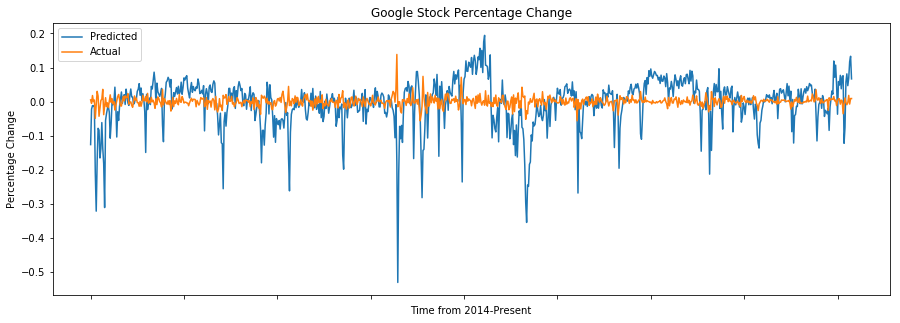

In [82]:
fig1, ax1 = plt.subplots(figsize=(15,5))
plt.plot(prediction, label="Predicted")
plt.plot(actual, label="Actual")
plt.xlabel("Time from 2014-Present")
plt.ylabel("Percentage Change")
plt.title("Google Stock Percentage Change")
ax1.set_xticklabels([])
plt.legend()

Conclusion
---
Althought the prediction was not very acurrate, it is most likely due to the lack of articles that were used and thus the model was unable to pick up an acurrate representation of the meaning of the words. For future work, it is important to make sure there is a reliable source of articles to be scraped or archived